# Estudio analítico de la iconografía del Museo Nacional Del Prado

In [1]:
#Import your libraries

import numpy as np
import pandas as pd
import re
import warnings
warnings.filterwarnings('ignore')
import pylab as plt
import seaborn as sns
import difflib
import networkx as nx
from pymongo import MongoClient
import plotly.express as px
from scipy.stats import ttest_ind

In [2]:
#%pip install pyecharts
from pyecharts import options as opts
from pyecharts.charts import Pie
from pyecharts.commons.utils import JsCode
from pyecharts.globals import ThemeType

# Importación de los datos desde MongoDB.

In [3]:
# Conectar a la base de datos MongoDB
client = MongoClient("mongodb://localhost:27017")
db = client["icongrafia_prado_completo"]

In [4]:
# Se obtienen el documento de la colección "obras_completo"
cursor = db.obras_completo.find()

# Convertir los documentos a un DataFrame
obras_completo = pd.DataFrame(list(cursor))

In [5]:
num_documentos = db.obras_completo.count_documents({})
num_documentos

655

In [6]:
cantidad_titulos_escuela_espanola = db.obras_completo.count_documents({"Escuela": "Española"})
cantidad_titulos_escuela_espanola 

368

# Exploración inicial de los datos.

Para llevar a cabo un análisis comprehensivo del dataframe presente, se procederá a realizar una exploración detallada de sus características fundamentales. 

Inicialmente, se examinarán las columnas que componen el dataframe, desglosando exhaustivamente la información contenida en cada una de ellas. Este paso es crucial para obtener una visión clara de las variables y el tipo de dato con el que contamos. También se evaluarán las dimensiones del dataframe para comprender la amplitud de la información que se está manejando. 

Se prestará especial atención a la presencia de valores nulos y duplicados. En caso de haberlos, se procederá a estudiarlos.  

Este proceso sienta las bases necesarias y proporcionaun punto de partida sólido para los análisis descriptivos y estadísticos que se realizarán más adelante.

In [7]:
obras_completo.head()

,_id,TituloID,Título,Autor,Fecha,Año,Escuela,Objetos,Fauna,Flora,Lugar,Personajes,Obra_uri,Imágenes,Fecha_rango
0,656e181b545b8cc16df86793,0,"""Floreros""","Nuzzi, Mario",1640 - 1642,1640,Italiana,Enseres domésticos ; Florero ; Instrumentos de...,NaN,Anémona (Anemone spp.) ; Gladiolo (Gladiolus s...,NaN,NaN,http://museodelprado.es/items/E22_Man-Made_Obj...,https://content3.cdnprado.net/imagenes/Documen...,1640 - 1642
1,656e181b545b8cc16df86794,1,"""La Anunciación""",Maestro de la Sisla,Hacia 1500,1495,Española,Libro,NaN,Azucena (Lilium candidum),NaN,Virgen María,http://museodelprado.es/items/E22_Man-Made_Obj...,https://content3.cdnprado.net/imagenes/Documen...,1495
2,656e181b545b8cc16df86795,2,"""Copa de la Vendimia""","Fontana, Annibale ; Taller de los Sarachi",1570 - 1600,1570,Italiana,NaN,NaN,Vid / Parra (Vitis vinifera),NaN,NaN,http://museodelprado.es/items/E22_Man-Made_Obj...,https://content3.cdnprado.net/imagenes/Documen...,1570 - 1600
3,656e181b545b8cc16df86796,3,"""Florero""","Pérez, Bartolomé",Hacia 1676,1671,Española,NaN,Artrópodos (Filo: Arthropoda),Ajenuz / Arañuela (Nigella damascena) ; Anémon...,NaN,NaN,http://museodelprado.es/items/E22_Man-Made_Obj...,https://content3.cdnprado.net/imagenes/Documen...,1671
4,656e181b545b8cc16df86797,4,"""La Inmaculada Concepción""","Maella, Mariano Salvador",Hacia 1781,1776,Española,Elementos heráldicos y nobiliarios ; Insignia ...,NaN,Azucena (Lilium candidum),NaN,Virgen María ; Ángel / ángeles,http://museodelprado.es/items/E22_Man-Made_Obj...,https://content3.cdnprado.net/imagenes/Documen...,1776


In [8]:
obras_completo['Escuela'].unique()

array(['Italiana', 'Española', 'Flamenca', 'Francesa',
       'Hispano-cartaginesa', 'Italiana ; Veneciana',
       'Castellana ; Española', 'Francesa ; Italiana', 'Holandesa',
       'Alemana', 'Española ; Madrileña', 'Italiana ; Napolitana',
       'Arte Clásico ; Roma', 'Boloñesa ; Italiana', 'Gala',
       'Desconocida', 'Púnica', 'Hispano-flamenca',
       'Española ; Valenciana', 'Florentina ; Italiana', 'Inglesa',
       'Sueca', 'Castellana ; Española ; Toledana',
       'Francesa ; Italiana ; Milanesa', 'Portuguesa'], dtype=object)

In [9]:
obras_completo = obras_completo[obras_completo['Escuela'] != 'Desconocida'] #Elimino las filas en las que la escuela es desconocida.
obras_completo = obras_completo.reset_index(drop=True)

In [10]:
obras_completo.columns

Index(['_id', 'TituloID', 'Título', 'Autor', 'Fecha', 'Año', 'Escuela',
       'Objetos', 'Fauna', 'Flora', 'Lugar', 'Personajes', 'Obra_uri',
       'Imágenes', 'Fecha_rango'],
      dtype='object')

In [11]:
obras_completo.isnull().sum()

_id              0
TituloID         0
Título           0
Autor            0
Fecha            0
Año              0
Escuela          0
Objetos        331
Fauna          462
Flora            0
Lugar          602
Personajes     343
Obra_uri         0
Imágenes         0
Fecha_rango      0
dtype: int64

In [12]:
obras_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   _id          649 non-null    object
 1   TituloID     649 non-null    int64 
 2   Título       649 non-null    object
 3   Autor        649 non-null    object
 4   Fecha        649 non-null    object
 5   Año          649 non-null    int64 
 6   Escuela      649 non-null    object
 7   Objetos      318 non-null    object
 8   Fauna        187 non-null    object
 9   Flora        649 non-null    object
 10  Lugar        47 non-null     object
 11  Personajes   306 non-null    object
 12  Obra_uri     649 non-null    object
 13  Imágenes     649 non-null    object
 14  Fecha_rango  649 non-null    object
dtypes: int64(2), object(13)
memory usage: 76.2+ KB


In [13]:
obras_completo.describe(include='object')

,_id,Título,Autor,Fecha,Escuela,Objetos,Fauna,Flora,Lugar,Personajes,Obra_uri,Imágenes,Fecha_rango
count,649,649,649,649,649,318,187,649,47,306,649,649,649
unique,649,456,299,324,24,213,110,303,26,145,649,649,296
top,656e181b545b8cc16df86793,"""Florero""",Anónimo,Siglo XVII,Española,Enseres domésticos ; Florero,Paloma (Columba ssp),Azucena (Lilium candidum),Alsasua ; España ; Navarra,Virgen María,http://museodelprado.es/items/E22_Man-Made_Obj...,https://content3.cdnprado.net/imagenes/Documen...,Siglo XVII
freq,1,68,80,81,368,19,30,79,4,18,1,1,81


In [14]:
obras_completo.describe()

,TituloID,Año
count,649.000000,649.000000
mean,326.206471,1694.241911
std,189.507705,234.762248
min,0.000000,-400.000000
25%,162.000000,1601.000000
50%,325.000000,1680.000000
75%,490.000000,1832.000000
max,654.000000,1931.000000


Tras un breve estudio del dataframe, se ha identificado la presencia de valores nulos especialmente en las cinco columnas correspondientes a los datos iconográficos de las obras. Algunos cuadros se caracterizan por contener únicamente una de las categorías, ya sea personajes, flora, fauna... Esta diversidad ha generado la aparición de valores nulos en las columnas correspondientes a los tipos de iconografía, como mencionaba anteriormente. 

Por este motivo, se procederá a rellenar los valores nulos en función de la naturaleza específica de cada obra y garantizar así la integridad de los datos para futuros análisis.

In [15]:
obras_completo['Objetos'] = obras_completo['Objetos'].fillna('Desconocidos')
obras_completo['Fauna'] = obras_completo['Fauna'].fillna('Desconocida')
obras_completo['Lugar'] = obras_completo['Lugar'].fillna('Desconocido')
obras_completo['Personajes'] = obras_completo['Personajes'].fillna('Desconocidos')

In [16]:
obras_completo.isnull().any()

_id            False
TituloID       False
Título         False
Autor          False
Fecha          False
Año            False
Escuela        False
Objetos        False
Fauna          False
Flora          False
Lugar          False
Personajes     False
Obra_uri       False
Imágenes       False
Fecha_rango    False
dtype: bool

Ahora comprobamos la presencia de duplicados. Con gran suerte, no encontramos ninguno, por lo que no centraremos más nuestro atención en este ambito.

In [17]:
duplicados = obras_completo[obras_completo.duplicated()]
duplicados

,_id,TituloID,Título,Autor,Fecha,Año,Escuela,Objetos,Fauna,Flora,Lugar,Personajes,Obra_uri,Imágenes,Fecha_rango


Con el propósito de facilitar futuros análisis descriptivos y estadísticos, se llevará a cabo la descomposición de los valores en cada una de las celdas seleccionadas mediante el método ".explode( )". 

Esto permitirá la separación de cada valor individual contenido en las celdas, facilitando así el poder realizar cálculos futuros como recuentos, porcentajes u otras tareas que requieran la manipulación de datos numéricos en lugar de categóricos.

In [18]:
cols = ['Personajes', 'Objetos', 'Fauna', 'Flora', 'Lugar']

In [19]:
for col in cols:
    obras_completo[col] = obras_completo[col].str.split(';')
    obras_completo = obras_completo.explode(col)
    obras_completo[col] = obras_completo[col].str.strip()

In [20]:
obras_completo = obras_completo.reset_index(drop=True)

In [21]:
obras_completo.head()

,_id,TituloID,Título,Autor,Fecha,Año,Escuela,Objetos,Fauna,Flora,Lugar,Personajes,Obra_uri,Imágenes,Fecha_rango
0,656e181b545b8cc16df86793,0,"""Floreros""","Nuzzi, Mario",1640 - 1642,1640,Italiana,Enseres domésticos,Desconocida,Anémona (Anemone spp.),Desconocido,Desconocidos,http://museodelprado.es/items/E22_Man-Made_Obj...,https://content3.cdnprado.net/imagenes/Documen...,1640 - 1642
1,656e181b545b8cc16df86793,0,"""Floreros""","Nuzzi, Mario",1640 - 1642,1640,Italiana,Enseres domésticos,Desconocida,Gladiolo (Gladiolus spp.),Desconocido,Desconocidos,http://museodelprado.es/items/E22_Man-Made_Obj...,https://content3.cdnprado.net/imagenes/Documen...,1640 - 1642
2,656e181b545b8cc16df86793,0,"""Floreros""","Nuzzi, Mario",1640 - 1642,1640,Italiana,Enseres domésticos,Desconocida,Lirio (Iris germanica),Desconocido,Desconocidos,http://museodelprado.es/items/E22_Man-Made_Obj...,https://content3.cdnprado.net/imagenes/Documen...,1640 - 1642
3,656e181b545b8cc16df86793,0,"""Floreros""","Nuzzi, Mario",1640 - 1642,1640,Italiana,Enseres domésticos,Desconocida,Mundillo / Bola de nieve (Viburnum opulus L.),Desconocido,Desconocidos,http://museodelprado.es/items/E22_Man-Made_Obj...,https://content3.cdnprado.net/imagenes/Documen...,1640 - 1642
4,656e181b545b8cc16df86793,0,"""Floreros""","Nuzzi, Mario",1640 - 1642,1640,Italiana,Enseres domésticos,Desconocida,Peonía (Paeonia),Desconocido,Desconocidos,http://museodelprado.es/items/E22_Man-Made_Obj...,https://content3.cdnprado.net/imagenes/Documen...,1640 - 1642


Tras el procedimiento anterior, se ha observado un aumento considerable en la cantidad de valores nulos en el dataframe. 

Para abordar esta situación, se rellenarán estos nuevos valores nulos de manera análoga a la estrategia previamente empleada:

In [22]:
obras_completo['Objetos'] = obras_completo['Objetos'].fillna('Desconocidos')
obras_completo['Fauna'] = obras_completo['Fauna'].fillna('Desconocida')
obras_completo['Lugar'] = obras_completo['Lugar'].fillna('Desconocido')
obras_completo['Personajes'] = obras_completo['Personajes'].fillna('Desconocidos')

En base a la columna de años, se procederá a la creación de rangos temporales con el objetivo de facilitar análisis subsiguientes. 

Se establecerán rangos de 200 años cada uno, con la finalidad de gestionar y comprender de manera más accesible la distribución temporal de los datos.

In [23]:
rango_total = obras_completo['Año'].min(), obras_completo['Año'].max()
print("Rango total de años:", rango_total)

Rango total de años: (-400, 1931)


In [24]:
particiones = [-400, -200, 0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]

etiquetas = ['(-400) - (-200)', '(-201) - 0', '1 - 200', '201 - 400', '401 - 600', '601 - 800', '801 - 1000', '1001 - 1200', '1201 - 1400', '1401 - 1600', '1601 - 1800', '1801 - 2000']

#Asignación de etiquetas a cada rango:
obras_completo['Año_rango'] = pd.cut(obras_completo['Año'], particiones, labels=etiquetas)

obras_completo[['Año', 'Año_rango']].head(5)

,Año,Año_rango
0,1640,1601 - 1800
1,1640,1601 - 1800
2,1640,1601 - 1800
3,1640,1601 - 1800
4,1640,1601 - 1800


Se llevará a cabo la eliminación de ciertas columnas que, si bien podrían ser relevantes para otras tareas, resultan prescindibles para el estudio específico que se llevará a cabo a continuación. 

Estas columnas se descartarán con el propósito de simplificar el conjunto de datos y concentrarse de manera más efectiva en las variables cruciales para el análisis inmediato.

In [25]:
cols_eliminar = ["TituloID", "Fecha", "Obra_uri", "Imágenes"]

In [26]:
obras_completo = obras_completo.drop(cols_eliminar, axis=1) # A continuación elimino otras que se encuentran en una parte anterior de la tabla pero que tampoco necesito tenerlas en cuenta de cara al estudio que se pretende realizar.

In [27]:
prueba = obras_completo.head(1000)

# Exportación del DataFrame.

Exportamos este Dataframe, pues es el que luego utilizaremos para llevar a cabo el resto del estudio de elementos iconográficos en las pobras del Museo del Prado.

In [28]:
obras_completo.to_csv("/Users/karmelealonsoaia/Desktop/ironhack_labs/PROYECTOS/project_final/data/data_clean/obras_completo.csv", index=False)

# Análisis de personajes a lo largo del tiempo.

En la fase inicial de este estudio, se enfocará la atención en realizar un análisis detallado acerca de cómo ha evolucionado la representación de personajes iconográficos a lo largo de los años. 

Se busca identificar tendencias y patrones en la representación artística, examinando las fluctuaciones en la frecuencia de los personajes a través del tiempo. 

Este análisis permitirá comprender mejor las preferencias y enfoques de los artistas en distintas épocas, explorando si existen cambios significativos en la representación de ciertos tipos de personajes y discerniendo qué aspectos específicos han sido destacados o modificados a lo largo de la historia. 

El objetivo último es extraer algunas conclusiones para una mejor comprensión de las dinámicas artísticas.

El estudio se llevará a cabo mediante una serie de enfoques analíticos que abordarán diversas facetas de la representación de personajes a lo largo del tiempo:

1. Estudio Comparativo/Descriptivo:
Esta fase implica una comparación entre la frecuencia de aparición de varios personajes a lo largo de los años. Este enfoque permitirá identificar posibles correlaciones entre eventos históricos o cambios artísticos y las variaciones en la representación de personajes a lo largo del tiempo.
Para captar las tendencias temporales se plantearán gráficos de líneas temporales que nos muestren la frecuencia de aparición de un personaje específico a lo largo del tiempo.

2. Estudio estadísticos y Análisis de cambios significativos:
Se investigarán cambios bruscos en la frecuencia de aparición de personajes a lo largo de ciertos períodos de tiempo. 
Se realizará un análisis detallado para examinar cómo la diversidad de personajes ha variado a lo largo de los años. Utilizando algunos índices específicos, se cuantificará la presencia de diferentes tipos de personajes en distintas épocas.

Estas metodologías seleccionadas se complementan entre sí para ofrecer un análisis profundo y preciso de la evolución temporal de la representación de personajes, considerando aspectos comparativos, cambios significativos, diversidad y análisis estadístico para obtener una visión completa y fundamentada de la dinámica artística a lo largo del tiempo.

In [29]:
personajes_año_rango = obras_completo[['Personajes', 'Año_rango']]

In [30]:
personajes_año_rango = personajes_año_rango[personajes_año_rango['Personajes'] != 'Desconocidos']
personajes_año_rango = personajes_año_rango.reset_index(drop=True)

In [31]:
personajes_año_rango.head()

,Personajes,Año_rango
0,Virgen María,1401 - 1600
1,Virgen María,1601 - 1800
2,Virgen María,1601 - 1800
3,Virgen María,1601 - 1800
4,Virgen María,1601 - 1800


In [32]:
personajes_año_rango.shape

(12657, 2)

In [33]:
personajes_año_rango['Personajes'].value_counts()

Personajes
Virgen María                2733
Jesús                       1508
Hera/Juno                   1025
Afrodita/Venus               844
Flora                        706
                            ... 
San Nicodemo                   1
Ninfas                         1
José de Arimatea               1
Eugenia Martínez Vallejo       1
Europa                         1
Name: count, Length: 139, dtype: int64

En este contexto, donde nos movemos con datos categóricos, la tabla de contingencia es lo adecuado para realizar un análisis que nos permitirá examinar la distribución conjunta de las categorías en ambas columnas: "Personajes" y "Año_rango". Esto nos permitirá visualizar de manera precisa cómo se vinculan los personajes con los distintos rangos de años. 

Este enfoque nos permitirá entender la relación entre los diferentes personajes y el momento en el que eran representados.

In [34]:
tabla_contingencia = pd.crosstab(personajes_año_rango['Personajes'], personajes_año_rango['Año_rango'])
tabla_contingencia

Año_rango,(-400) - (-200),(-201) - 0,1001 - 1200,1401 - 1600,1601 - 1800,1801 - 2000
Personajes,,,,,,
Adonis,0,0,0,4,14,0
Adán,0,0,1,2,3,3
Afrodita/Venus,0,0,0,4,778,62
Aglae,0,0,0,0,4,13
Alberto de Austria,0,0,0,0,136,0
...,...,...,...,...,...,...
"Tudor, María",0,0,0,4,0,0
Virgen María,0,0,0,221,2306,206
"Vázquez de la Varga, Pura",0,0,0,0,0,2


Una vez generada la tabla de contingencia, podemos llevar a cabo un análisis más específico al identificar los nombres que predominan en cada rando de años. Un enfoque efectivo para lograr esto es obtener el nombre que tiene la frecuencia máxima en cada rango, revelando así los personajes más recurrentes en cada período temporal.

In [35]:
personajes_mas_comunes = tabla_contingencia.idxmax(axis=1)
personajes_mas_comunes

Personajes
Adonis                       1601 - 1800
Adán                         1601 - 1800
Afrodita/Venus               1601 - 1800
Aglae                        1801 - 2000
Alberto de Austria           1601 - 1800
                                ...     
Tudor, María                 1401 - 1600
Virgen María                 1601 - 1800
Vázquez de la Varga, Pura    1801 - 2000
Ángel / ángeles              1601 - 1800
Ángeles Ortiz, Manuel        1801 - 2000
Length: 139, dtype: category
Categories (12, object): ['(-400) - (-200)' < '(-201) - 0' < '1 - 200' < '201 - 400' ... '1201 - 1400' < '1401 - 1600' < '1601 - 1800' < '1801 - 2000']

Me gustaría encontrar el personaje que, de forma general, más se repite:

In [36]:
total_por_personaje = tabla_contingencia.sum(axis=1)

personaje_mas_comun = total_por_personaje .idxmax()
print("Personaje más común:", personaje_mas_comun)

Personaje más común: Virgen María


Y a continuación el rango de fechas en el que más destaca el personaje recién obtenido:

In [37]:
datos_personaje_mas_comun = personajes_año_rango[personajes_año_rango['Personajes'] == personaje_mas_comun]

rango_mas_comun = datos_personaje_mas_comun['Año_rango'].value_counts().idxmax() #rango de fechas más común para el personaje Virgen María.
print("Rango de fechas más común para", personaje_mas_comun, ":", rango_mas_comun)

Rango de fechas más común para Virgen María : 1601 - 1800


Ahora lo haré con los diez personajes más frecuentes, ya que estos serán los protagonistas principales en la mayoría de los estudios subsiguientes. 

Al seleccionar un grupo más reducido de personajes lograremos una representación visual más clara en los gráficos.

In [38]:
personajes_mas_comunes = personajes_año_rango['Personajes'].value_counts().nlargest(10).index #10 personajes más comunes.

for personaje in personajes_mas_comunes:
    datos_personaje = personajes_año_rango[personajes_año_rango['Personajes'] == personaje]
    rango_mas_comun = datos_personaje['Año_rango'].value_counts().idxmax()
    print(f"{personaje}: {rango_mas_comun}")

Virgen María: 1601 - 1800
Jesús: 1601 - 1800
Hera/Juno: 1601 - 1800
Afrodita/Venus: 1601 - 1800
Flora: 1601 - 1800
San José: 1601 - 1800
Deméter/Ceres: 1601 - 1800
San Juan Bautista: 1601 - 1800
Ángel / ángeles: 1601 - 1800
Dionisio / Baco: 1801 - 2000


A continuación, procederé a crear un gráfico circular (pie chart) que destacará a los diez personajes más frecuentes en nuestro dataframe, es decir, aquellos que han sido más comunmente representados. Este gráfico ofrecerá una visualización clara y concisa de la distribución de la representación de personajes, permitiéndonos identificar visualmente la prevalencia de cada uno de los diez personajes principales en el conjunto de datos.

In [39]:
personajes_año_rango['Frecuencia'] = personajes_año_rango.groupby(['Año_rango', 'Personajes'])['Personajes'].transform('count')

In [40]:
personajes_mas_comunes = personajes_año_rango['Personajes'].value_counts().nlargest(10).index

# Filtro el DataFrame para incluir solo los 10 personajes más comunes
df_top_10 = personajes_año_rango[personajes_año_rango['Personajes'].isin(personajes_mas_comunes)]

# Calculo la frecuencia total
frecuencia_total = df_top_10['Frecuencia'].sum()

# Creo el gráfico de pastel
pie_chart = (
    Pie(init_opts=opts.InitOpts(theme=ThemeType.LIGHT))
    .add(
        series_name="Personajes",
        data_pair=[(personaje, personaje_total['Frecuencia'].sum() / frecuencia_total * 100) 
                   for personaje, personaje_total in df_top_10.groupby('Personajes')],
        radius=["30%", "75%"],
        center=["50%", "50%"],
        label_opts=opts.LabelOpts(is_show=False, position="center"),
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="Distribución de Frecuencia de Personajes"),
        legend_opts=opts.LegendOpts(pos_left="80%", orient="vertical"),
    )
)


pie_chart.render_notebook()


Ahora procederé a la creación de un Gráfico de Líneas Temporales por Personaje (utlizaré en este caso también solo los diez más comunes), una representación visual que ilustrará la evolución de la frecuencia de cada personaje a lo largo de los años. Este gráfico general nos ofrecerá una visión panorámica de la distribución temporal de los personajes más comunes, permitiéndonos identificar tendencias generales en su representación a lo largo de las diferentes épocas.

En un análisis más detallado, he diseñado un segundo gráfico que se enfoca en los años en los que los personajes más comunes alcanzan su mayor recurrencia. Este "zoom" nos proporcionará una visión más específica y detallada de los períodos temporales en los que estos personajes destacan de manera significativa.

Posteriormente, hemos segmentado la información en gráficos individuales, uno por cada personaje. Este enfoque más específico nos permitirá examinar la frecuencia de representación de cada personaje de manera aislada.

In [ ]:
personajes_año_rango.head()

,Personajes,Año_rango,Frecuencia
0,Virgen María,1401 - 1600,221
1,Virgen María,1601 - 1800,2306
2,Virgen María,1601 - 1800,2306
3,Virgen María,1601 - 1800,2306
4,Virgen María,1601 - 1800,2306


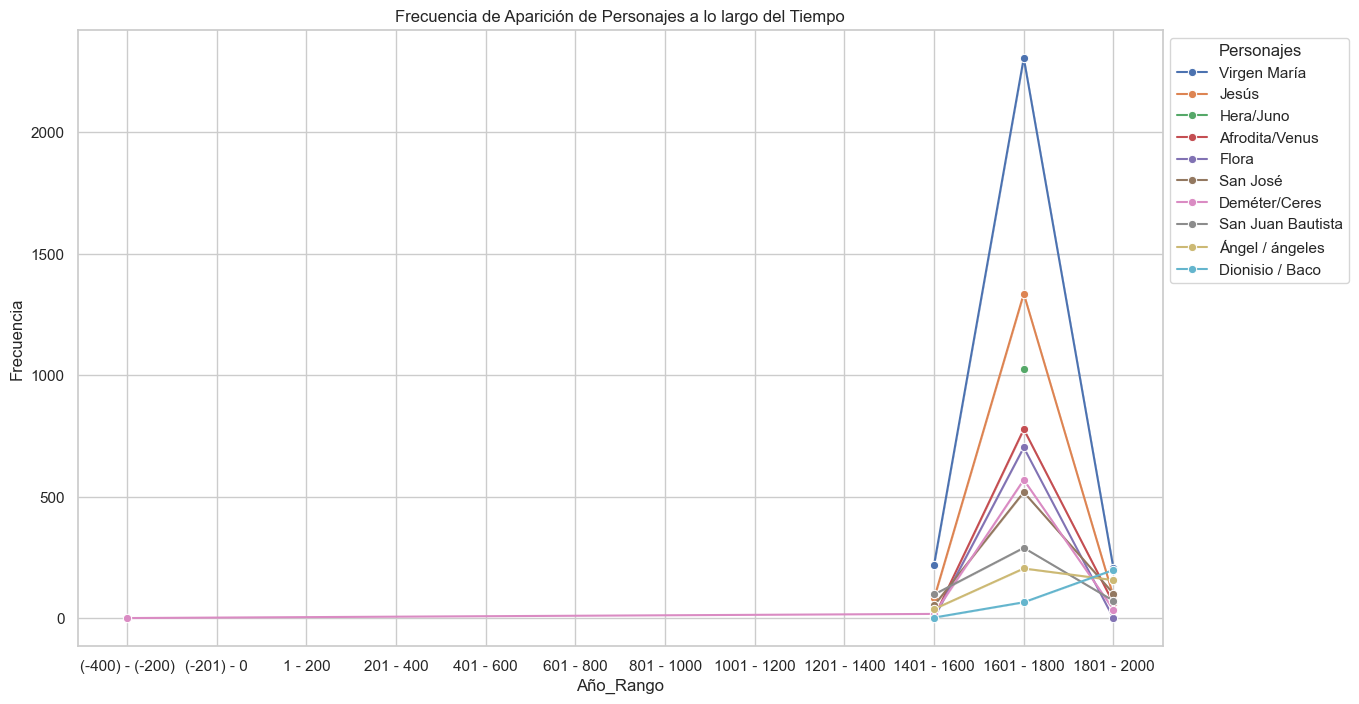

In [ ]:
# Se establece el estilo de la cuadrícula:
sns.set(style="whitegrid")


plt.figure(figsize=(14, 8))

# Se itera sobre los personajes y dibuja líneas con colores diferentes:
for i, personaje in enumerate(personajes_mas_comunes):
    sns.lineplot(x='Año_rango', y='Frecuencia', data=df_top_10[df_top_10['Personajes'] == personaje], label=personaje, marker='o')

# Se ajusta el diseño del gráfico:
plt.title('Frecuencia de Aparición de Personajes a lo largo del Tiempo')
plt.xlabel('Año_Rango')
plt.ylabel('Frecuencia')
plt.legend(title='Personajes', loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

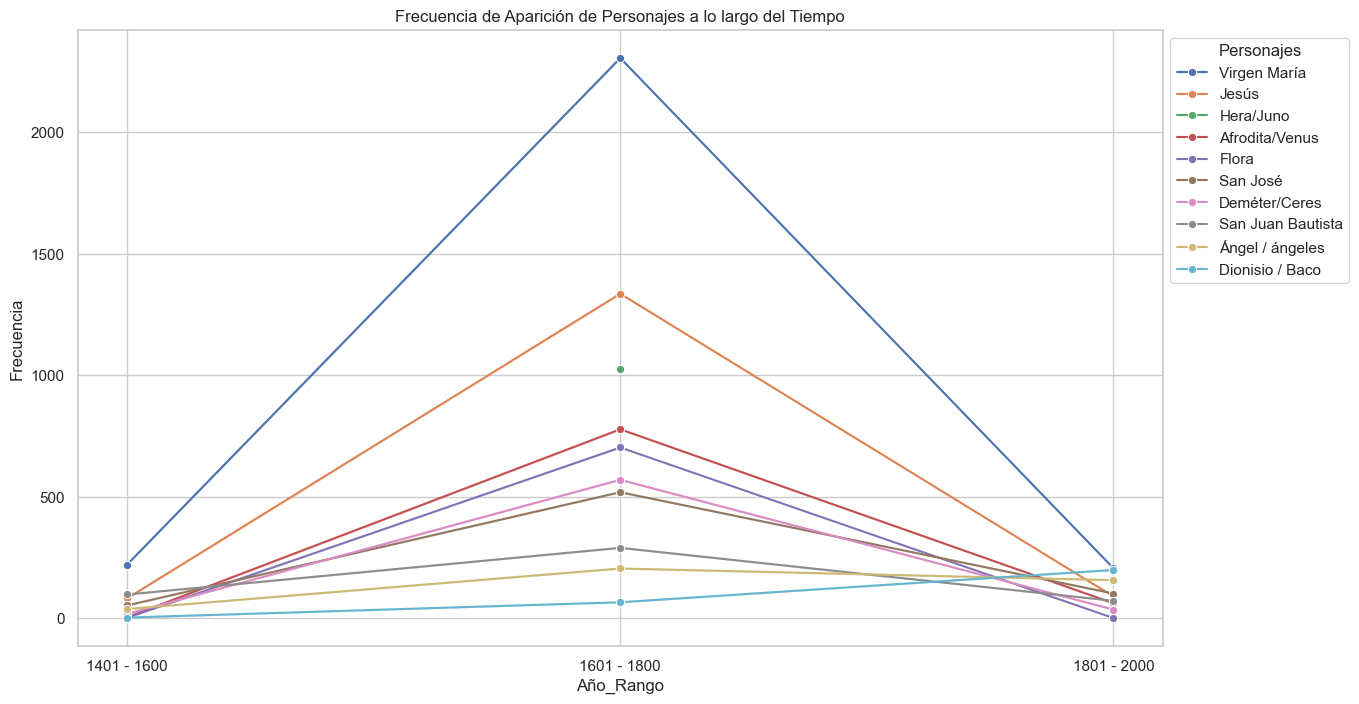

In [ ]:
# Se incluyen solo los diez personajes más comunes y el rango de años más destacado en los mismos:
top_10_data = personajes_año_rango[
    (personajes_año_rango['Personajes'].isin(personajes_mas_comunes)) &
    (personajes_año_rango['Año_rango'].str.contains('1400|1500|1600|1700|1800|1900|2000'))
]

# Se establece el estilo de la cuadrícula:
sns.set(style="whitegrid")

plt.figure(figsize=(14, 8))

# Se itera sobre los personajes y dibuja líneas con colores diferentes:
for i, personaje in enumerate(personajes_mas_comunes):
    sns.lineplot(x='Año_rango', y='Frecuencia', data=top_10_data[top_10_data['Personajes'] == personaje], label=personaje, marker='o')

# Se ajusta el diseño del gráfico:
plt.title('Frecuencia de Aparición de Personajes a lo largo del Tiempo')
plt.xlabel('Año_Rango')
plt.ylabel('Frecuencia')
plt.legend(title='Personajes', loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

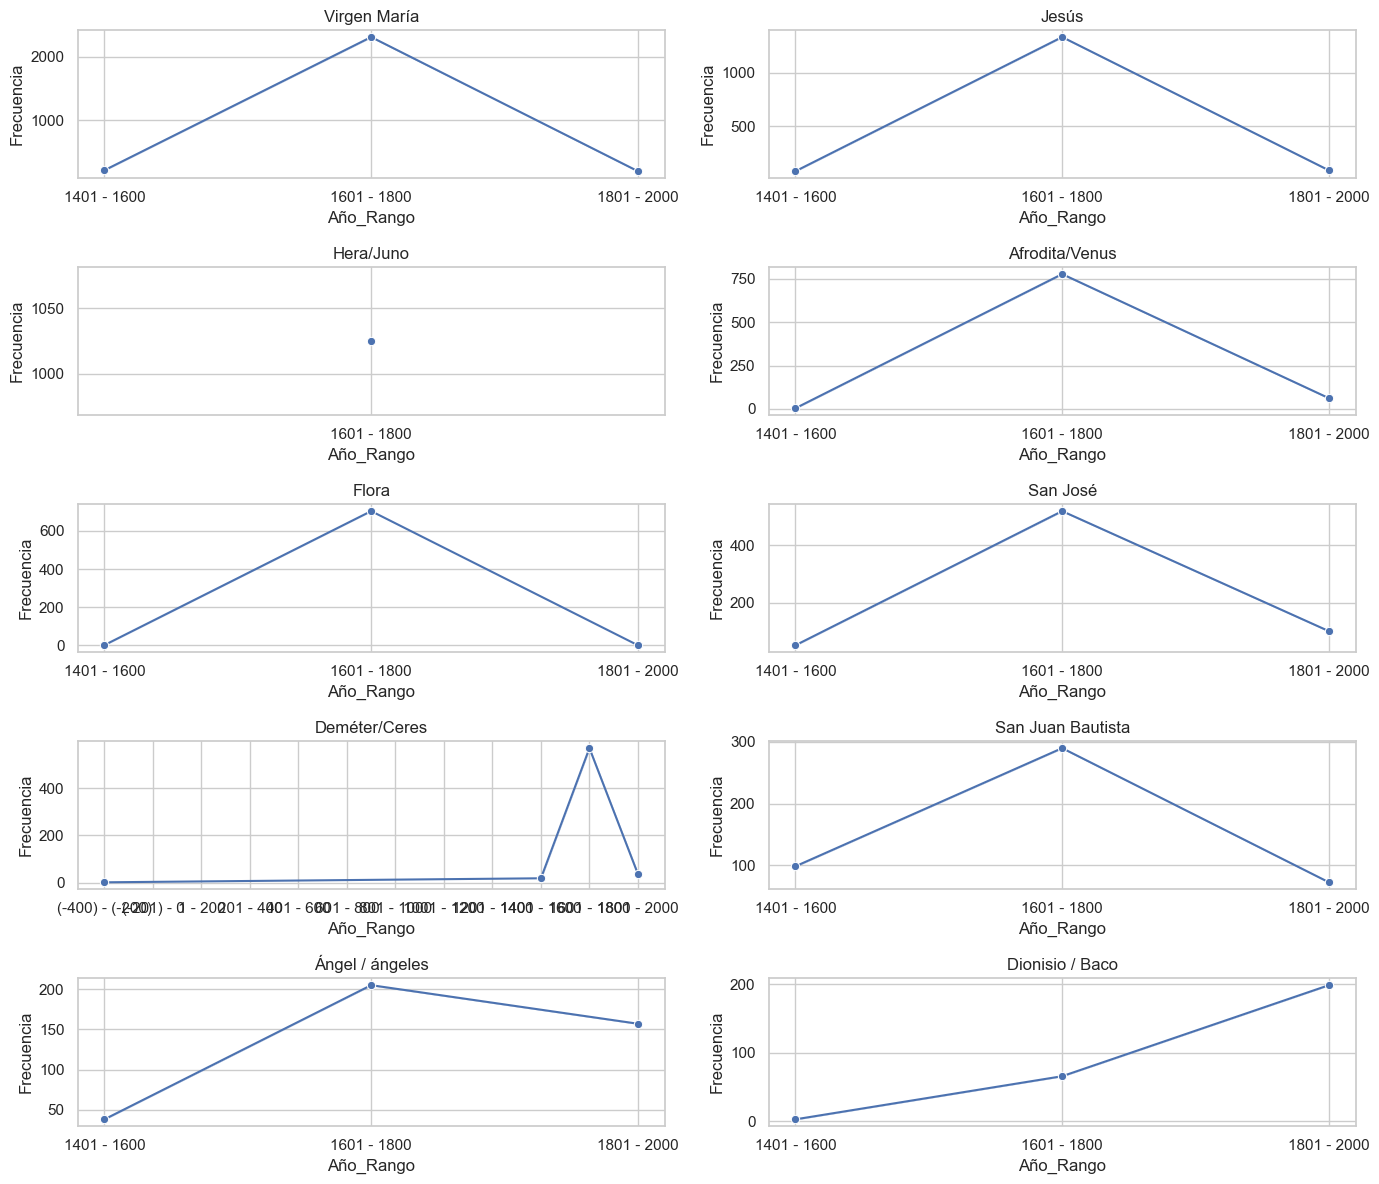

In [ ]:

top_10_data = personajes_año_rango[personajes_año_rango['Personajes'].isin(personajes_mas_comunes)] #Filtro para incluir solo los personajes más comunes.

sns.set(style="whitegrid")

# Se crean subgráficos para cada personaje:
plt.figure(figsize=(14, 12))
for i, personaje in enumerate(personajes_mas_comunes, 1):
    plt.subplot(5, 2, i)
    sns.lineplot(x='Año_rango', y='Frecuencia', data=top_10_data[top_10_data['Personajes'] == personaje], marker='o')
    plt.title(personaje)
    plt.xlabel('Año_Rango')
    plt.ylabel('Frecuencia')

# Se ajusta el diseño de los subgráficos:
plt.tight_layout()

plt.show()

4.  de Cambios Significativos: Identificación de Cambios Bruscos: Investiga y analiza cambios significativos en la frecuencia de aparición de personajes en ciertos períodos de tiempo.

Vamos ahora a identificar y analizar cambios bruscos en la frecuencia de aparición de personages a lo largo del tiempo. Nos centraremos en identificar y comprender los momentos en los que se produjeron variaciones significativas en la aparición de estos personajes. Este análisis nos permitirá investigar de cerca los periodos específicos en los que se observan cambios bruscos en la representación de los personajes.

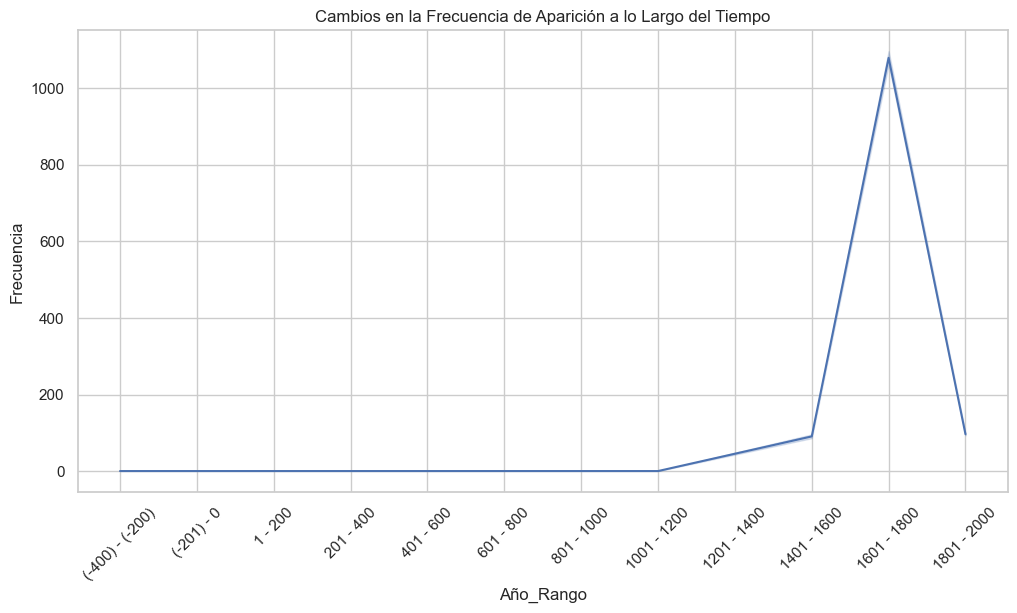

In [ ]:
# Gráfico de líneas para ver cambios a lo largo del tiempo
plt.figure(figsize=(12, 6))
sns.lineplot(x='Año_rango', y='Frecuencia', data=personajes_año_rango)
plt.title('Cambios en la Frecuencia de Aparición a lo Largo del Tiempo')
plt.xlabel('Año_Rango')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

Vamos a llevar a cabo un análisis estadístico para comparar dos periodos consecutivos, y para ello, optaremos por la aplicación de una prueba t de Student. Esta herramienta nos permitirá evaluar si existen diferencias significativas entre las medias de los dos periodos, proporcionando así evidencias estadísticos sobre la variación en la representación de los personajes a lo largo del tiempo.

In [ ]:
from scipy.stats import ttest_ind

# Se filtra el rango 1001 al 1400 para periodo_anterior:
periodo_anterior = personajes_año_rango.loc[(personajes_año_rango['Año_rango'] == '1001 - 1200') | (personajes_año_rango['Año_rango'] == '1201 - 1400'), 'Frecuencia']

# Se filtra el rango 1401 al 2000 para periodo_actual:
periodo_actual = personajes_año_rango.loc[(personajes_año_rango['Año_rango'] == '1401 - 1600') | (personajes_año_rango['Año_rango'] == '1601 - 2000'), 'Frecuencia'].shift(1).dropna()

resultado_prueba_t, p_valor = ttest_ind(periodo_anterior, periodo_actual)
resultado_prueba_t, p_valor

(-1.6844468848399714, 0.09239139762534457)

Aquí observamos dos resultados fundamentales:

- El "resultado_prueba_t": es un número que indica cuánto difieren las medias de los dos grupos en términos de desviación estándar. Un valor mayor en valor absoluto indica una mayor diferencia.

- El "p_valor": un valor p bajo (generalmente menos de 0.05) sugiere que hay evidencia suficiente para rechazar la hipótesis nula de que no hay diferencia significativa.
Entonces, si el valor p es menor que un umbral comúnmente aceptado (como 0.05), se suele interpretar como que hay una diferencia significativa entre las frecuencias de los dos períodos.

Así, como conclusión, el resultado de la prueba t para la comparación de dos periodos consecutivos arrojó un valor t de aproximadamente -1.68 y un p-valor de alrededor de 0.092. Este resultado sugiere que la diferencia entre las medias de los dos periodos no es estadísticamente significativa a un nivel de confianza del 95%.

En términos más simples, no hay evidencia suficiente para rechazar la hipótesis nula, que establece que no hay diferencia significativa entre los dos periodos en términos de la representación de los personajes. El p-valor de 0.092 es mayor que el umbral típicamente utilizado de 0.05, lo que indica que no hay suficiente evidencia para concluir que la diferencia observada no se debe simplemente al azar.

# Análisis de los grupos compositivos más frecuentes entre personajes.

Observando la recurrencia de personajes a lo largo de las distintas épocas y su evolución en la representación artística, me surge la idea de explorar cómo se relacionan entre sí. 

En este sentido, considero interesante examinar si estos personajes suelen ser representados conjuntamente en un mismo cuadro, si aparecen de manera individual. En definitiva, cómo suelen ser representados y junto a qué. 

Para llevar a cabo esta exploración, agregaré ahora la columna que contiene los títulos de las obras. La presencia de varios personajes bajo un mismo título indica que han sido representados juntos. 

Con esta información, podremos analizar las tendencias y relaciones entre personajes a lo largo de la historia.

De nuevo, me centraré en loque sigue en los diez personajes más comunes, con el fin de que la representación sea más clara y evidente a la vista.

In [ ]:
titulo_personajes_año_rango = obras_completo[["Título", "Personajes", "Año_rango"]]
titulo_personajes_año_rango

,Título,Personajes,Año_rango
0,"""Floreros""",Desconocidos,1601 - 1800
1,"""Floreros""",Desconocidos,1601 - 1800
2,"""Floreros""",Desconocidos,1601 - 1800
3,"""Floreros""",Desconocidos,1601 - 1800
4,"""Floreros""",Desconocidos,1601 - 1800
...,...,...,...
21709,"""Niños jugando a los dados""",Desconocidos,1801 - 2000
21710,"""Niños jugando a los dados""",Desconocidos,1801 - 2000
21711,"""Niños jugando a los dados""",Desconocidos,1801 - 2000
21712,"""Niños jugando a los dados""",Desconocidos,1801 - 2000


In [ ]:
#Me deshazgo de todos los valores donde el personaje es "Desconocido":
titulo_personajes_año_rango = titulo_personajes_año_rango[titulo_personajes_año_rango['Personajes'] != 'Desconocidos']
titulo_personajes_año_rango = titulo_personajes_año_rango.reset_index(drop=True)

In [ ]:
titulo_personajes_año_rango

,Título,Personajes,Año_rango
0,"""La Anunciación""",Virgen María,1401 - 1600
1,"""La Inmaculada Concepción""",Virgen María,1601 - 1800
2,"""La Inmaculada Concepción""",Virgen María,1601 - 1800
3,"""La Inmaculada Concepción""",Virgen María,1601 - 1800
4,"""La Inmaculada Concepción""",Virgen María,1601 - 1800
...,...,...,...
12652,"""La Virgen con el Niño""",Jesús,1401 - 1600
12653,"""La Virgen con el Niño""",Jesús,1401 - 1600
12654,"""La Virgen con el Niño""",Virgen María,1401 - 1600
12655,"""La Virgen con el Niño""",Virgen María,1401 - 1600


In [ ]:
titulo_personajes_frecuencia = titulo_personajes_año_rango.groupby(['Título', 'Personajes']).size().reset_index(name='Frecuencia')

In [ ]:
# Calculo cuantos personajes contiene cada obra:
titulo_personajes_unicos = titulo_personajes_frecuencia.groupby('Título')['Personajes'].nunique().reset_index(name='Cantidad_Personajes_Unicos')

In [ ]:
titulo_personajes_unicos

,Título,Cantidad_Personajes_Unicos
0,"""A Francisco Martínez de la Rosa, en su muerte""",1
1,"""A Salustiano de Olózaga""",1
2,"""Adoración de los Reyes Magos""",4
3,"""Adoración del Sagrado Corazón de Jesús""",11
4,"""Adán antes de comer el fruto""",1
...,...,...
209,"""Venus descubre a Adonis muerto""",3
210,"""Venus, Adonis y Cupido""",3
211,"""Visión de Santa Teresa / Apuntes""",1
212,"""Visión de san Francisco en la Porciúncula""",4


In [ ]:
# Agrupo por el título para obtener la lista de los personajes representados en cada una de las obras:
titulo_personajes = titulo_personajes_frecuencia.groupby('Título')['Personajes'].unique().reset_index(name='Personajes_en_obra')
titulo_personajes

,Título,Personajes_en_obra
0,"""A Francisco Martínez de la Rosa, en su muerte""",[Francisco Martínez de la Rosa]
1,"""A Salustiano de Olózaga""",[Salustiano de Olózaga]
2,"""Adoración de los Reyes Magos""","[Jesús, Reyes Magos, San José, Virgen María]"
3,"""Adoración del Sagrado Corazón de Jesús""","[San Agustín, San Bernardo de Claraval, San Fr..."
4,"""Adán antes de comer el fruto""",[Adán]
...,...,...
209,"""Venus descubre a Adonis muerto""","[Adonis, Afrodita/Venus, Cupido/Eros]"
210,"""Venus, Adonis y Cupido""","[Adonis, Afrodita/Venus, Cupido/Eros]"
211,"""Visión de Santa Teresa / Apuntes""",[Ángel / ángeles]
212,"""Visión de san Francisco en la Porciúncula""","[Jesús, San Francisco de Asís, Virgen María, Á..."


In [ ]:
#Como decía, solo me interesan los 10 personajes que más aparecen en las obras:
top_10_personajes_en_obras = titulo_personajes_frecuencia.groupby('Personajes').sum()['Frecuencia'].nlargest(10).reset_index()
top_10_personajes_en_obras

,Personajes,Frecuencia
0,Virgen María,2733
1,Jesús,1508
2,Hera/Juno,1025
3,Afrodita/Venus,844
4,Flora,706
5,San José,674
6,Deméter/Ceres,625
7,San Juan Bautista,460
8,Ángel / ángeles,400
9,Dionisio / Baco,268


In [ ]:
#Selecciono solo los 10 personajes más recurrentes:
personajes_comunes = ["Virgen María", "Jesús", "Hera/Juno", "Afrodita/Venus", "Flora", "San José", "Deméter/Ceres", "San Juan Bautista", "Ángel / ángeles", "Dionisio / Baco"]

# Filtro el DataFrame original para incluir solo las filas que contengan las obras en las que aparecen los 10 personajes recién mencionados:
titulo_personajes_comunes = titulo_personajes[titulo_personajes['Personajes_en_obra'].apply(lambda x: any(personaje in x for personaje in personajes_comunes))]
titulo_personajes

,Título,Personajes_en_obra
0,"""A Francisco Martínez de la Rosa, en su muerte""",[Francisco Martínez de la Rosa]
1,"""A Salustiano de Olózaga""",[Salustiano de Olózaga]
2,"""Adoración de los Reyes Magos""","[Jesús, Reyes Magos, San José, Virgen María]"
3,"""Adoración del Sagrado Corazón de Jesús""","[San Agustín, San Bernardo de Claraval, San Fr..."
4,"""Adán antes de comer el fruto""",[Adán]
...,...,...
209,"""Venus descubre a Adonis muerto""","[Adonis, Afrodita/Venus, Cupido/Eros]"
210,"""Venus, Adonis y Cupido""","[Adonis, Afrodita/Venus, Cupido/Eros]"
211,"""Visión de Santa Teresa / Apuntes""",[Ángel / ángeles]
212,"""Visión de san Francisco en la Porciúncula""","[Jesús, San Francisco de Asís, Virgen María, Á..."


Decido ahora utilizar un mapa de calor en el análisis de las relaciones entre personajes en las obras de arte, pues me parece que representa de manera clara las frecuencias de aparición conjunta. Los mapas de calor ofrecen una perspectiva intuitiva que facilita la identificación de conexiones entre los diferentes personajes estudiados.

La paleta de colores simplifica la identificación de los personajes que tienden a ser representados juntos con mayor frecuencia, así como aquellos que comparten menor presencia en las obras.

In [ ]:
titulo_personajes

,Título,Personajes_en_obra
0,"""A Francisco Martínez de la Rosa, en su muerte""",[]
1,"""A Salustiano de Olózaga""",[]
2,"""Adoración de los Reyes Magos""","[Jesús, San José, Virgen María]"
3,"""Adoración del Sagrado Corazón de Jesús""",[Virgen María]
4,"""Adán antes de comer el fruto""",[]
...,...,...
209,"""Venus descubre a Adonis muerto""",[Afrodita/Venus]
210,"""Venus, Adonis y Cupido""",[Afrodita/Venus]
211,"""Visión de Santa Teresa / Apuntes""",[Ángel / ángeles]
212,"""Visión de san Francisco en la Porciúncula""","[Jesús, Virgen María, Ángel / ángeles]"


In [ ]:
# Creamos la matriz de correlaciones
correlation_matrix = pd.DataFrame(0, index=personajes_comunes, columns=personajes_comunes)

for personajes_en_obra in titulo_personajes['Personajes_en_obra']:
    for i in range(len(personajes_en_obra)):
        for j in range(i + 1, len(personajes_en_obra)):
            personaje1 = personajes_en_obra[i]
            personaje2 = personajes_en_obra[j]

            correlation_matrix.at[personaje1, personaje2] += 1
            correlation_matrix.at[personaje2, personaje1] += 1

# Convertimos la matriz a un formato adecuado para Plotly
correlation_matrix_plotly = correlation_matrix.unstack().reset_index()
correlation_matrix_plotly.columns = ['Personaje1', 'Personaje2', 'Frecuencia']

# Creamos el heatmap interactivo con Plotly Express
fig = px.imshow(correlation_matrix.values,
                x=personajes_comunes,
                y=personajes_comunes,
                labels=dict(x="Personaje 1", y="Personaje 2", color="Frecuencia"),
                title='Mapa de Correlaciones entre los 10 Personajes Más Comunes',
                color_continuous_scale="Viridis",
                width=800, height=600)

print(correlation_matrix.values)

# Añadimos el texto de frecuencia a la matriz de correlaciones
annotations = []
for i, row in enumerate(correlation_matrix.values):
    for j, value in enumerate(row):
        annotations.append(dict(text=str(value), x=personajes_comunes[j], y=personajes_comunes[i],
                                xref='x1', yref='y1', showarrow=False))

fig.update_layout(annotations=annotations)


# Mostramos la figura
fig.show()

[[ 0 38  0  0  0 19  0  9 21  0]
 [38  0  0  0  0 20  0  9 16  0]
 [ 0  0  0  1  1  0  1  0  0  0]
 [ 0  0  1  0  1  0  1  0  0  0]
 [ 0  0  1  1  0  0  1  0  0  0]
 [19 20  0  0  0  0  0  5  7  0]
 [ 0  0  1  1  1  0  0  0  0  1]
 [ 9  9  0  0  0  5  0  0  2  0]
 [21 16  0  0  0  7  0  2  0  0]
 [ 0  0  0  0  0  0  1  0  0  0]]


Como puede verse, este mapa de calor proporciona una representación gráfica de las relaciones y frecuencias entre los personajes, con colores y números que permiten una interpretación visual de las asociaciones más fuertes o frecuentes.

En términos de conclusiones, los valores en la diagonal de la matriz reflejan la frecuencia individual de aparición de cada personaje, mientras que los valores fuera de la diagonal indican cuántas veces dos personajes específicos comparten espacio en una obra. Además, los colores nos permiten inferir como de fuerte es este vínculo entre dos personajes.

# Análisis de personajes según las escuelas

La rica diversidad de las escuelas artísticas ha desempeñado un papel crucial en la evolución del arte a lo largo de la historia. En este contexto, la representación de personajes en las obras de arte se presenta como un fascinante objeto de estudio.

Me propongo ahora llevar a cabo un estudio sobre la representación de personajes en obras de diferentes escuelas artísticas. El objetivo principal de esta investigación es analizar cómo la presencia de ciertos personajes específicos varía según las distintas escuelas artísticas. 

Para ello, exploraré la distribución y frecuencia de estos personajes en diversas escuelas, con el fin de identificar patrones, preferencias y cambios temáticos que puedan estar vinculados a movimientos artísticos específicos. Este análisis permitirá arrojar luz sobre la relación entre la elección de personajes y las características estilísticas y temáticas distintivas de cada escuela artística.

In [ ]:
personajes_escuela = obras_completo[['Personajes', 'Escuela', 'Año_rango']]

In [ ]:
personajes_escuela = personajes_escuela[personajes_escuela['Personajes'] != 'Desconocidos'] #Elimino las filas en las que el personajes es deconocido.
personajes_escuela = personajes_escuela.reset_index(drop=True)

In [ ]:
personajes_escuela = personajes_escuela[personajes_escuela['Escuela'] != 'Desconocida'] #Elimino las filas en las que la Escuela es desconocida.
personajes_escuela = personajes_escuela.reset_index(drop=True)

In [ ]:
personajes_escuela.head()

,Personajes,Escuela,Año_rango
0,Virgen María,Española,1401 - 1600
1,Virgen María,Española,1601 - 1800
2,Virgen María,Española,1601 - 1800
3,Virgen María,Española,1601 - 1800
4,Virgen María,Española,1601 - 1800


In [ ]:
personajes_escuela['Escuela'].unique()

array(['Española', 'Flamenca', 'Italiana', 'Hispano-cartaginesa',
       'Italiana ; Veneciana', 'Castellana ; Española', 'Francesa',
       'Alemana', 'Española ; Madrileña', 'Italiana ; Napolitana',
       'Boloñesa ; Italiana', 'Hispano-flamenca', 'Española ; Valenciana',
       'Inglesa', 'Sueca', 'Castellana ; Española ; Toledana',
       'Francesa ; Italiana ; Milanesa', 'Púnica'], dtype=object)

Procedo ahora a aplicar el mismo proceso que había hecho al comienzo con los diferentes elementos iconográficos:

In [ ]:
personajes_escuela['Escuela'] = personajes_escuela['Escuela'].str.split(';')

In [ ]:
personajes_escuela = personajes_escuela.explode('Escuela')

personajes_escuela = personajes_escuela.reset_index(drop=True)

In [ ]:
personajes_escuela['Escuela'] = personajes_escuela['Escuela'].str.strip()

In [ ]:
personajes_escuela['Escuela'].unique()

array(['Española', 'Flamenca', 'Italiana', 'Hispano-cartaginesa',
       'Veneciana', 'Castellana', 'Francesa', 'Alemana', 'Madrileña',
       'Napolitana', 'Boloñesa', 'Hispano-flamenca', 'Valenciana',
       'Inglesa', 'Sueca', 'Toledana', 'Milanesa', 'Púnica'], dtype=object)

A continuación, busco simplificar la estructura del análisis, focalizándonos en las corrientes artísticas más prominentes. Para ello, llevaré a cabo la unificación de las diversas escuelas artísticas, considerando la relación de "escuela-subescuela" entre las mismas. Optaré por consolidar únicamente las escuelas más amplias que, a su vez, engloban a las subescuelas correspondientes.

In [ ]:
def modificar_escuela(escuela):
    if pd.notna(escuela):
        escuela = str(escuela)  # Convertir a cadena si no es nulo
        if 'Veneciana' in escuela:
            return 'Italiana'
        elif 'Castellana' in escuela:
            return 'Española'
        elif 'Valenciana' in escuela:
            return 'Española'
        elif 'Napolitana' in escuela:
            return 'Italiana'
        elif 'Boloñesa' in escuela:
            return 'Italiana'
        elif 'Madrileña' in escuela:
            return 'Española'
        elif 'Florentina' in escuela:
            return 'Italiana'
        elif 'Toledana' in escuela:
            return 'Española'
        elif 'Milanesa' in escuela:
            return 'Italiana'
    
    return escuela

personajes_escuela['Escuela'] = personajes_escuela['Escuela'].apply(modificar_escuela)

Me parece en este caso también interesante hacer una tabla de contingencia, pues es una herramienta muy buena, al tratarse de una estructura ordenada y cuantitativa que facilita la interpretación, para explorar y entender las relaciones entre las diferentes variables categóricas que queremos estudiar.

In [ ]:
tabla_contingencia_personajes_escuela = pd.crosstab(personajes_escuela['Personajes'], personajes_escuela['Escuela'])
tabla_contingencia_personajes_escuela

Escuela,Alemana,Española,Flamenca,Francesa,Hispano-cartaginesa,Hispano-flamenca,Inglesa,Italiana,Púnica,Sueca
Personajes,,,,,,,,,,
Adonis,0,14,0,0,0,0,0,4,0,0
Adán,0,4,3,0,0,0,0,4,0,0
Afrodita/Venus,0,76,684,0,0,0,0,84,0,0
Aglae,0,0,4,13,0,0,0,0,0,0
Alberto de Austria,0,0,136,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
"Tudor, María",0,0,4,0,0,0,0,0,0,0
Virgen María,0,467,2240,46,0,3,0,54,0,0
"Vázquez de la Varga, Pura",0,2,0,0,0,0,0,0,0,0


In [ ]:
personajes_escuela.shape

(12956, 3)

Tras la creación de la tabla de contingencia, me dispongo a identificar los personajes que predominan en cada "Escuela".

In [ ]:
personajes_mas_comunes_escuela = tabla_contingencia_personajes_escuela.idxmax(axis=1)
personajes_mas_comunes_escuela

Personajes
Adonis                       Española
Adán                         Española
Afrodita/Venus               Flamenca
Aglae                        Francesa
Alberto de Austria           Flamenca
                               ...   
Tudor, María                 Flamenca
Virgen María                 Flamenca
Vázquez de la Varga, Pura    Española
Ángel / ángeles              Española
Ángeles Ortiz, Manuel        Española
Length: 139, dtype: object

In [ ]:
total_por_personaje_escuela = tabla_contingencia_personajes_escuela.sum(axis=1)

personaje_mas_comun_escuela = total_por_personaje_escuela .idxmax()
print("Personaje más común:", personaje_mas_comun_escuela)

Personaje más común: Virgen María


In [ ]:
datos_personaje_mas_comun_escuela = personajes_escuela[personajes_escuela['Personajes'] == personaje_mas_comun_escuela]

escuela_mas_comun = datos_personaje_mas_comun_escuela['Escuela'].value_counts().idxmax()
print("Escuela más común para", personaje_mas_comun_escuela, ":", escuela_mas_comun)

Escuela más común para Virgen María : Flamenca


In [ ]:
personajes_mas_comunes_escuela = personajes_escuela['Personajes'].value_counts().nlargest(10).index

for personaje in personajes_mas_comunes_escuela:
    datos_personaje_escuela = personajes_escuela[personajes_escuela['Personajes'] == personaje]
    escuela_mas_comun = datos_personaje_escuela['Escuela'].value_counts().idxmax()
    print(f"Escuela más común para {personaje}: {escuela_mas_comun}")

Escuela más común para Virgen María: Flamenca
Escuela más común para Jesús: Flamenca
Escuela más común para Hera/Juno: Flamenca
Escuela más común para Afrodita/Venus: Flamenca
Escuela más común para Flora: Flamenca
Escuela más común para San José: Flamenca
Escuela más común para Deméter/Ceres: Flamenca
Escuela más común para San Juan Bautista: Flamenca
Escuela más común para Ángel / ángeles: Española
Escuela más común para Dionisio / Baco: Española


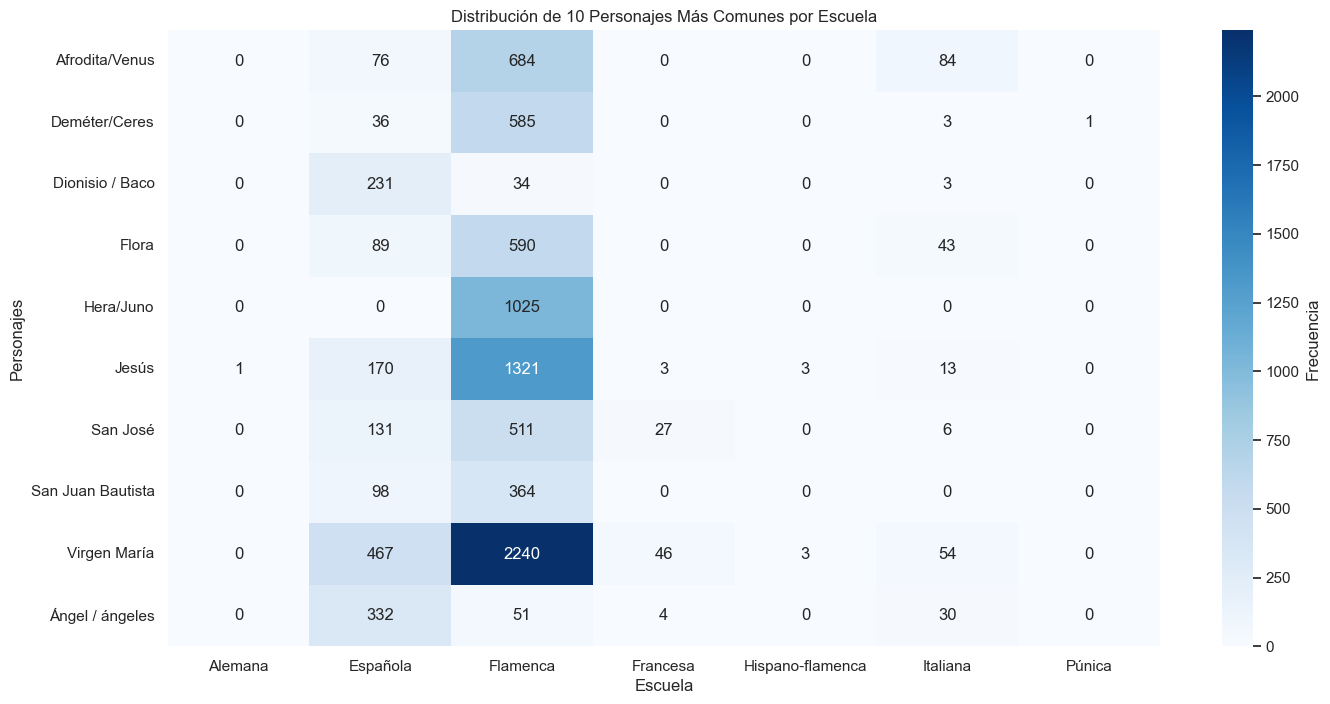

In [ ]:
diez_personajes_mas_comunes = personajes_escuela['Personajes'].value_counts().nlargest(10).index

df_personajes_comunes = personajes_escuela[personajes_escuela['Personajes'].isin(diez_personajes_mas_comunes)]

# Se cuenta la frecuencia:
tabla_contingencia_personajes_escuela = pd.crosstab(df_personajes_comunes['Personajes'], df_personajes_comunes['Escuela'])

plt.figure(figsize=(16, 8))
sns.heatmap(tabla_contingencia_personajes_escuela, cmap='Blues', annot=True, fmt='d', cbar_kws={'label': 'Frecuencia'})
plt.title('Distribución de 10 Personajes Más Comunes por Escuela')
plt.xlabel('Escuela')
plt.ylabel('Personajes')
plt.show()

Me propongo visualizar la frecuencia de los diez personajes más comunes y su aparición en las diferentes escuelas artísticas a través de un gráfico de barras. 

Esta representación gráfica permitirá una comprensión visual inmediata de cómo se distribuyen los personajes en las distintas escuelas artísticas.

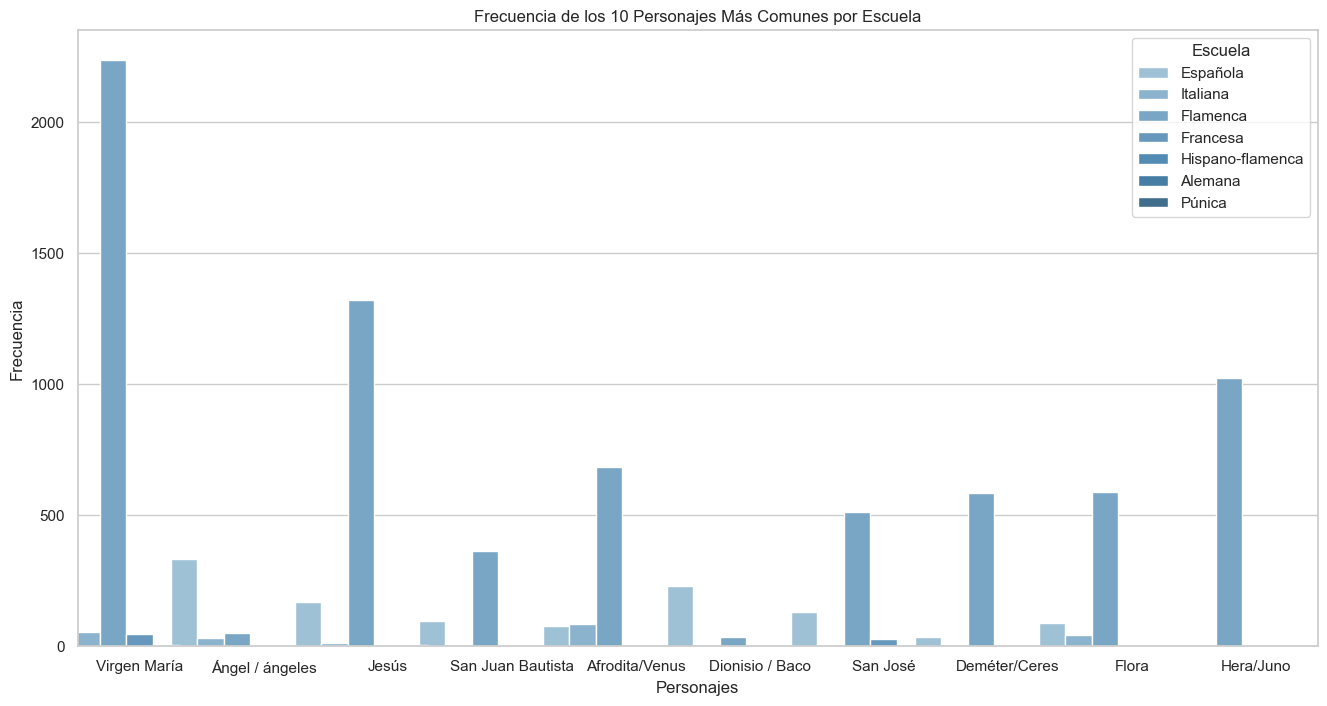

In [ ]:
colores_blues_oscuros = sns.color_palette("Blues_d", 10)

# Gráfico de barras para la relación entre 'Personajes' y 'Escuela' con barras más anchas y colores más oscuros
plt.figure(figsize=(16, 8))
sns.countplot(x='Personajes', hue='Escuela', data=df_personajes_comunes, palette=colores_blues_oscuros, saturation=0.75, width=1.5)
plt.title('Frecuencia de los 10 Personajes Más Comunes por Escuela')
plt.xlabel('Personajes')
plt.ylabel('Frecuencia')
plt.legend(title='Escuela', bbox_to_anchor=(1, 1))
plt.show()

# Creación de tablas para Streamlit

In [ ]:
obras_completo.head()

,_id,Título,Autor,Año,Escuela,Objetos,Fauna,Flora,Lugar,Personajes,Imágenes,Fecha_rango,Año_rango
0,656e181b545b8cc16df86793,"""Floreros""","Nuzzi, Mario",1640,Italiana,Enseres domésticos,Desconocida,Anémona (Anemone spp.),Desconocido,Desconocidos,https://content3.cdnprado.net/imagenes/Documen...,1640 - 1642,1601 - 1800
1,656e181b545b8cc16df86793,"""Floreros""","Nuzzi, Mario",1640,Italiana,Enseres domésticos,Desconocida,Gladiolo (Gladiolus spp.),Desconocido,Desconocidos,https://content3.cdnprado.net/imagenes/Documen...,1640 - 1642,1601 - 1800
2,656e181b545b8cc16df86793,"""Floreros""","Nuzzi, Mario",1640,Italiana,Enseres domésticos,Desconocida,Lirio (Iris germanica),Desconocido,Desconocidos,https://content3.cdnprado.net/imagenes/Documen...,1640 - 1642,1601 - 1800
3,656e181b545b8cc16df86793,"""Floreros""","Nuzzi, Mario",1640,Italiana,Enseres domésticos,Desconocida,Mundillo / Bola de nieve (Viburnum opulus L.),Desconocido,Desconocidos,https://content3.cdnprado.net/imagenes/Documen...,1640 - 1642,1601 - 1800
4,656e181b545b8cc16df86793,"""Floreros""","Nuzzi, Mario",1640,Italiana,Enseres domésticos,Desconocida,Peonía (Paeonia),Desconocido,Desconocidos,https://content3.cdnprado.net/imagenes/Documen...,1640 - 1642,1601 - 1800


In [ ]:
personajes_streamlit = obras_completo[['Personajes', 'Escuela', 'Año_rango', 'Año', 'Título']]

In [ ]:
personajes_streamlit = personajes_streamlit[personajes_streamlit['Personajes'] != 'Desconocidos'] #Elimino las filas en las que el personajes es deconocido.
personajes_streamlit = personajes_streamlit.reset_index(drop=True)

In [ ]:
objetos_streamlit = obras_completo[['Objetos', 'Escuela', 'Año_rango', 'Año', 'Título']]

In [ ]:
objetos_streamlit = objetos_streamlit[objetos_streamlit['Objetos'] != 'Desconocidos'] #Elimino las filas en las que el personajes es deconocido.
objetos_streamlit = objetos_streamlit.reset_index(drop=True)

In [ ]:
fauna_streamlit = obras_completo[['Fauna', 'Escuela', 'Año_rango', 'Año', 'Título']]

In [ ]:
fauna_streamlit = fauna_streamlit[fauna_streamlit['Fauna'] != 'Desconocida'] #Elimino las filas en las que el personajes es deconocido.
fauna_streamlit = fauna_streamlit.reset_index(drop=True)

In [ ]:
flora_streamlit = obras_completo[['Flora', 'Escuela', 'Año_rango', 'Año', 'Título']]

In [ ]:
flora_streamlit = flora_streamlit[flora_streamlit['Flora'] != 'Desconocida'] #Elimino las filas en las que el personajes es deconocido.
flora_streamlit = flora_streamlit.reset_index(drop=True)

In [ ]:
lugar_streamlit = obras_completo[['Lugar', 'Escuela', 'Año_rango', 'Año', 'Título']]

In [ ]:
lugar_streamlit = lugar_streamlit[lugar_streamlit['Lugar'] != 'Desconocido'] #Elimino las filas en las que el personajes es deconocido.
lugar_streamlit = lugar_streamlit.reset_index(drop=True)

In [ ]:
lugar_streamlit["Lugar"].unique()

array(['Alicante', 'Elche', 'España', 'Las Navas', 'Ávila', 'El Escorial',
       'Madrid', 'Valencia', 'Italia', 'Guadarrama', 'Francia',
       'Normandía', 'Cantabria', 'San Vicente de la Barquera', 'Sevilla',
       'Alsasua', 'Navarra', 'Granada', 'Asturias', 'Picos de Europa',
       'Palermo', 'Sicilia', 'Magreb', 'Marruecos', 'Buñol', 'Bruselas',
       'Bélgica', 'Brabante, Tervuren', 'Gran Canaria', 'Islas Canarias',
       'Aranjuez', 'El Pardo', 'Roma', 'Frascati', 'Salamanca', 'Venecia'],
      dtype=object)

In [ ]:
lugares_excluir = ["España", "Italia", "Bélgica", "Francia", "Marruecos", "Bruselas"]
indices_excluir = lugar_streamlit[lugar_streamlit['Lugar'].isin(lugares_excluir)].index
lugar_streamlit = lugar_streamlit.drop(indices_excluir)

In [ ]:
lugar_streamlit["Lugar"].unique()

array(['Alicante', 'Elche', 'Las Navas', 'Ávila', 'El Escorial', 'Madrid',
       'Valencia', 'Guadarrama', 'Normandía', 'Cantabria',
       'San Vicente de la Barquera', 'Sevilla', 'Alsasua', 'Navarra',
       'Granada', 'Asturias', 'Picos de Europa', 'Palermo', 'Sicilia',
       'Magreb', 'Buñol', 'Brabante, Tervuren', 'Gran Canaria',
       'Islas Canarias', 'Aranjuez', 'El Pardo', 'Roma', 'Frascati',
       'Salamanca', 'Venecia'], dtype=object)

# Exportación de los DataFrames

In [1]:
#personajes_streamlit.to_csv("/Users/karmelealonsoaia/Desktop/ironhack_labs/PROYECTOS/project_final/data/data_clean/data_streamlit/personajes_streamlit.csv", index=False)
#objetos_streamlit.to_csv("/Users/karmelealonsoaia/Desktop/ironhack_labs/PROYECTOS/project_final/data/data_clean/data_streamlit/objetos_streamlit.csv", index=False)
#fauna_streamlit.to_csv("/Users/karmelealonsoaia/Desktop/ironhack_labs/PROYECTOS/project_final/data/data_clean/data_streamlit/fauna_streamlit.csv", index=False)
#flora_streamlit.to_csv("/Users/karmelealonsoaia/Desktop/ironhack_labs/PROYECTOS/project_final/data/data_clean/data_streamlit/flora_streamlit.csv", index=False)
#lugar_streamlit.to_csv("/Users/karmelealonsoaia/Desktop/ironhack_labs/PROYECTOS/project_final/data/data_clean/data_streamlit/lugar_streamlit.csv", index=False)

